In [12]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [13]:
# 1. Kết nối đến database PostgreSQL
conn = psycopg2.connect(
    dbname="marketing_campaign", 
    user="postgres", 
    password="Mayvabien_1911pg",
    host="localhost", 
    port="1911"
)

In [14]:
# 2. Lấy dữ liệu
query_transactions = "SELECT customer_id, campaign_id, transaction_id, transaction_date, amount FROM transactions"
query_campaigns = "SELECT customer_id, campaign_id FROM customer_campaigns"
query_customers = "SELECT customer_id, age, income FROM customers"

df_transactions = pd.read_sql(query_transactions, conn)
df_campaigns = pd.read_sql(query_campaigns, conn)
df_customers = pd.read_sql(query_customers, conn)

conn.close()

C:\Users\thanh\AppData\Local\Temp\ipykernel_15272\3415443626.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_transactions = pd.read_sql(query_transactions, conn)
C:\Users\thanh\AppData\Local\Temp\ipykernel_15272\3415443626.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_campaigns = pd.read_sql(query_campaigns, conn)
C:\Users\thanh\AppData\Local\Temp\ipykernel_15272\3415443626.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_customers = pd.read_sql(query_customers, conn)


In [15]:
# 3. Tính conversion cho từng khách (1 nếu có giao dịch, 0 nếu không)
# Merge customer_campaigns với transactions để xác định khách nào mua
df_merged = df_campaigns.merge(df_transactions[['customer_id', 'campaign_id', 'transaction_id']], 
                                on=['customer_id', 'campaign_id'], 
                                how='left')

df_merged['conversion'] = df_merged['transaction_id'].notnull().astype(int)

In [16]:

# 4. Tính conversion_rate mỗi campaign
conversion_rate_df = df_merged.groupby('campaign_id')['conversion'].mean().reset_index()
conversion_rate_df['conversion_rate_percent'] = (conversion_rate_df['conversion'] * 100).round(2)

print(conversion_rate_df)

   campaign_id  conversion  conversion_rate_percent
0            1    0.837209                    83.72
1            2    0.805195                    80.52


In [11]:
# 5. Tính Conversion Rate đúng cách:

# - Tổng số khách được assign vào Campaign A và B
total_customers_a = df_campaigns[df_campaigns['campaign_id'] == 1]['customer_id'].nunique()
total_customers_b = df_campaigns[df_campaigns['campaign_id'] == 2]['customer_id'].nunique()

# - Số khách thực sự đã thực hiện giao dịch
purchased_customers_a = df_transactions[df_transactions['campaign_id'] == 1]['customer_id'].nunique()
purchased_customers_b = df_transactions[df_transactions['campaign_id'] == 2]['customer_id'].nunique()

# - Tính Conversion Rate
conversion_rate_a = purchased_customers_a / total_customers_a
conversion_rate_b = purchased_customers_b / total_customers_b

# 6. In kết quả
print(f"Conversion Rate for Campaign A: {conversion_rate_a:.2%}")
print(f"Conversion Rate for Campaign B: {conversion_rate_b:.2%}")

Conversion Rate for Campaign A: 72.00%
Conversion Rate for Campaign B: 67.39%


In [17]:
# 5. T-Test: So sánh tỷ lệ chuyển đổi giữa 2 campaign
conversion_a = df_merged[df_merged['campaign_id'] == 1]['conversion']
conversion_b = df_merged[df_merged['campaign_id'] == 2]['conversion']

t_stat, p_value = stats.ttest_ind(conversion_a, conversion_b)

print(f"T-Statistic for Conversion Rate: {t_stat}")
print(f"P-Value for Conversion Rate: {p_value}")


T-Statistic for Conversion Rate: 0.5307407106151176
P-Value for Conversion Rate: 0.5963298104529998


In [18]:
# 6. T-Test: So sánh doanh thu (revenue)
revenue_a = df_transactions[df_transactions['campaign_id'] == 1]['amount']
revenue_b = df_transactions[df_transactions['campaign_id'] == 2]['amount']

t_stat_revenue, p_value_revenue = stats.ttest_ind(revenue_a, revenue_b)

print(f"T-Statistic for Revenue: {t_stat_revenue}")
print(f"P-Value for Revenue: {p_value_revenue}")

T-Statistic for Revenue: 1.0528724871042776
P-Value for Revenue: 0.29432295724177404


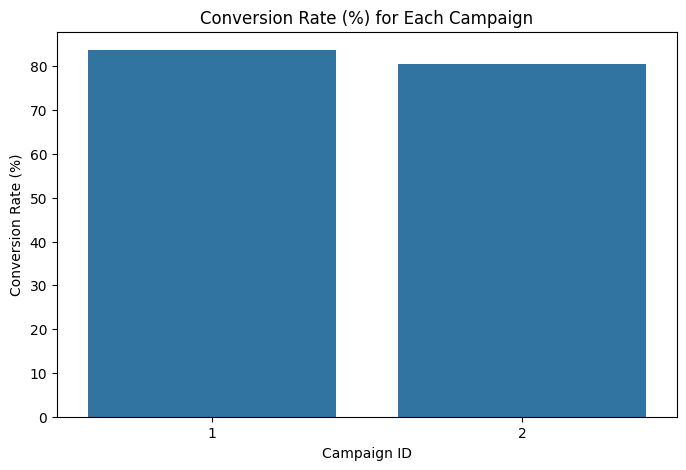

In [19]:
# 7. Vẽ biểu đồ conversion rate
plt.figure(figsize=(8, 5))
sns.barplot(x='campaign_id', y='conversion_rate_percent', data=conversion_rate_df)
plt.title('Conversion Rate (%) for Each Campaign')
plt.ylabel('Conversion Rate (%)')
plt.xlabel('Campaign ID')
plt.show()


In [20]:
# 8. Logistic Regression: Dự đoán khả năng mua hàng
# Merge thêm thông tin customer (age, income)
df_model = df_merged.merge(df_customers, on='customer_id', how='left')

# X: đặc trưng, y: biến mục tiêu
X = df_model[['age', 'income']]
y = df_model['conversion']

# Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Huấn luyện Logistic Regression
model = LogisticRegression()
model.fit(X_train, y_train)

# Dự đoán
y_pred = model.predict(X_test)
accuracy = (y_pred == y_test).mean()

print(f"Accuracy of Logistic Regression Model: {accuracy:.2%}")

Accuracy of Logistic Regression Model: 78.79%
